In [1]:
import numpy as np
#from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
import scipy.io
mat = scipy.io.loadmat('Car_Dataset_hyst_10s_N1000_v3.mat')
RV = mat['param'].T 
tin = mat['t']
# # mat['resp_all'].shape
xlow_all = mat['accel_LF'].T 
# mat = scipy.io.loadmat('DeepONet_degrading_data_v2.mat')
#xhigh_all = mat['accel_HF'].T
xhigh_all = mat['disp_HF'].T

In [4]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'accel_HF', 'accel_LF', 'disp_HF', 'disp_LF', 'p_mean', 'p_var', 'param', 't'])

In [5]:
mat['param'].T.shape

(1000, 5)

In [6]:
mat = scipy.io.loadmat('road_surface.mat')
w1 = mat['w1'] 

In [7]:
w1.shape

(1, 601)

In [8]:
data_min = w1.min()
data_max = w1.max()

normalized_w1 = (w1 - data_min) / (data_max - data_min) * 2 - 1

In [9]:
data_min = xhigh_all.min()
data_max = xhigh_all.max()

normalized_xhigh_all = (xhigh_all - data_min) / (data_max - data_min) * 2 - 1

In [10]:
xhigh_all.shape

(601, 1000)

In [11]:
tin.shape

(1, 601)

In [12]:
normalized_w1.shape

(1, 601)

In [13]:
normalized_w1[0,:].shape

(601,)

In [14]:
io=np.zeros((100,601,2))

In [15]:
io[0,:,0]=normalized_w1[0,:]

In [16]:
io[0,:,0].shape

(601,)

In [17]:
io.shape

(100, 601, 2)

In [18]:
nt = 601 
ni = 1000 # Number of parameter combinations 
nin = 7

np.random.seed(0)
io = np.zeros((ni,int(nt),nin))
op = np.zeros((ni,int(nt))) 
# xlow_all = np.zeros((ni,int(nt)))
# xhigh_all = np.zeros((ni,int(nt)))
tmax = 10 # For training 10s data used


for i in range(ni): 
    io[i,:,0] = (w1[0,:])
    io[i,:,1] = -1.0+2*(tin-np.amin(tin))/(tmax-np.amin(tin))
    
    for j in range(5): 
        io[i,:,2+j] = -1.0+2*(RV[i,j]*np.ones((nt,))-np.amin(RV[:,j]))/(np.amax(RV[:,j])-np.amin(RV[:,j])) 
   
#     op[i,:] = (-1.0+(xhigh_all[:,i]-xlow_all[:,i]))/2.0 # For BF training
    op[i,:] = (-1.0+(xhigh_all[:,i]))/2.0 # For HF training

In [19]:
io.shape

(1000, 601, 7)

In [510]:
RV.shape

(1000, 5)

### Without Stiffness

In [18]:
import os
from datetime import datetime
direct= os.path.join(os.getcwd(),'logs')
today_date = datetime.now().strftime('%Y-%m-%d')

In [19]:
nt = 601 
ni = 1000 # Number of parameter combinations 
nin = 2

np.random.seed(0)
io = np.zeros((ni,int(nt),nin))
op = np.zeros((ni,int(nt))) 
# xlow_all = np.zeros((ni,int(nt)))
# xhigh_all = np.zeros((ni,int(nt)))
tmax = 10 # For training 10s data used


for i in range(ni): 
    io[i,:,0] = normalized_w1[0,:]
    io[i,:,1] = -1.0+2*(tin-np.amin(tin))/(tmax-np.amin(tin))   
#     op[i,:] = (-1.0+(xhigh_all[:,i]-xlow_all[:,i]))/2.0 # For BF training
    op[i,:] = normalized_xhigh_all[:,i] # For HF training
    #op[i,:] = xhigh_all[:,i]
  

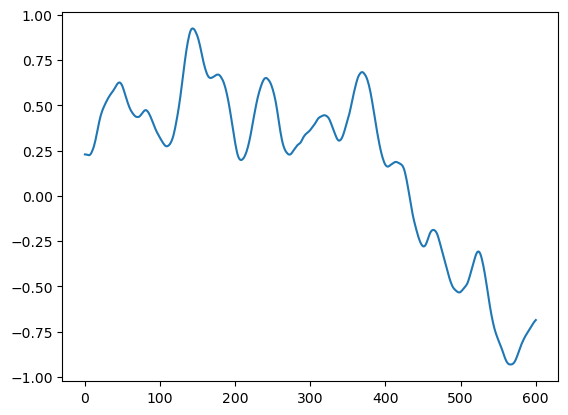

In [20]:
plt.plot(op[1,:])

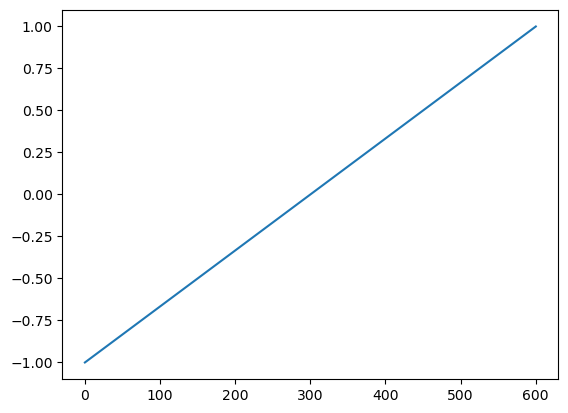

In [21]:
plt.plot(io[1,:,1])

In [22]:
io.shape

(1000, 601, 2)

In [23]:
op.shape

(1000, 601)

In [24]:
io_train=io[:50,:,:]
op_train=op[:50,:]

In [25]:
io_train.shape

(50, 601, 2)

In [26]:
op_train.shape

(50, 601)

In [27]:
x=io_train.reshape(-1,2)

In [28]:
y=op_train.reshape(-1,1)

In [29]:
x=torch.tensor(x, dtype=torch.float32)
y=torch.tensor(y, dtype=torch.float32)

In [30]:
shuffled_indicies=torch.randperm(x.shape[0])

In [31]:
shuffled_indicies

tensor([18827, 26770, 11090,  ..., 29175,  4266,  9648])

In [243]:
torch.save(shuffled_indicies,'indiciies')

In [244]:
shuffled_indicies=torch.load('indiciies')

In [32]:
shuffled_indicies.shape

torch.Size([30050])

In [33]:
x_torch=x[shuffled_indicies]

In [34]:
y_torch=y[shuffled_indicies]

In [259]:
model_car = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=2, out_features=100),
    nn.BatchNorm1d(50),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=1),
    nn.BatchNorm1d(1)
)

In [35]:
relu=nn.ReLU()
elu=nn.ELU()
sigmoid=nn.Sigmoid()
tanh=nn.Tanh()

In [108]:
act_list=[sigmoid,relu,elu,tanh]

In [109]:
bnn_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": 0.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}

In [143]:
def model_maker_torchbnn(act):
    
    model_car = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=2, out_features=100),
    nn.BatchNorm1d(100),
    act,
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=100),      
    nn.BatchNorm1d(100),
    act,
    bnn.BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=1), 
    nn.BatchNorm1d(1),
    )
    
    return model_car
    


In [144]:
import torch.nn as nn
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss

# Define the deterministic neural network

def model_maker(act,bnn_parameters): 
    
    model_car = nn.Sequential(
        nn.Linear(in_features=2, out_features=50),  # Replace BayesLinear with Linear
        nn.BatchNorm1d(50),
        act,
        nn.Linear(in_features=50, out_features=100),  # Replace BayesLinear with Linear
        nn.BatchNorm1d(100),
        act,
        nn.Linear(in_features=100, out_features=1),  # Replace BayesLinear with Linear
        nn.BatchNorm1d(1)
    )
    dnn_to_bnn(model_car, bnn_parameters)
    
    return model_car

In [145]:
from torch.utils.data import DataLoader

In [146]:
dataset = torch.utils.data.TensorDataset(x_torch, y_torch)

In [147]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15025, shuffle=True)

In [148]:
batch_x, batch_y = next(iter(dataloader))

In [149]:
batch_x.shape

torch.Size([15025, 2])

In [150]:
batch_y.shape

torch.Size([15025, 1])

In [151]:
bnn_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": 0.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}

In [152]:
def plotter(io,op,model_variables,activation,mse_list,kl_losses):
    
    x_test=torch.from_numpy(io[90,:,:]).float()
    y_test=op[50:,:]
    y_test_mean=np.mean(y_test,axis=0)
    y_test_sd=np.std(y_test,axis=0)
    num_realizations = 1000
    all_fits = []
    for _ in range(num_realizations):
        fit = model_car(x_test)
        all_fits.append(fit.data.numpy())
        
    all_fits = np.array(all_fits)
    mean_fit = np.mean(all_fits, axis=0)
    std_fit = np.std(all_fits, axis=0)
    l2_norm=np.linalg.norm(mean_fit-y_test_mean.reshape(-1,1))
    normalized_l2_norm=l2_norm/(np.linalg.norm(y_test_mean.reshape(-1,1)))
    l2_norm_std=np.linalg.norm(std_fit-y_test_sd.reshape(-1,1))
    normalized_l2_sd=l2_norm_std/(np.linalg.norm(y_test_sd.reshape(-1,1)))
    meanplus=mean_fit+ 2*std_fit
    meanminus=mean_fit-2*std_fit

    print(activation)

    print('-----------------')
    
    print(" MEAN VALIDATION ERROR-----{}".format(normalized_l2_norm))
    print(" SD VALIDATION ERROR------{}".format(normalized_l2_sd))
    
    print('\n')
 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    ax2.plot(mse_list, label='MSE Error', color='blue')
    ax2.set_xlabel('Pass')
    ax2.set_ylabel('MSE Error')
    ax2.set_title('Mean Squared Error (MSE) over Epochs {}'.format(activation))
    ax2.legend()
    ax2.grid(True)
    
    # Create another subplot for KL Loss
    ax1.plot(kl_losses, label='KL Loss', color='green')
    ax1.set_ylabel('KL Loss')
    ax1.set_title('Kullback-Leibler (KL) Loss over Epochs {}'.format(activation))
    ax1.legend(loc='upper right')
    
    print(model_variables)
    print('\n')
    print(model_car)
    print('\n')
    plt.figure()
    
    plt.plot(np.arange(0,601),y_test_mean,label='test')
    plt.plot(mean_fit,label='mean_fit')
    plt.legend()
    plt.fill_between(np.arange(0,601), (mean_fit - 2 * std_fit).squeeze(), (mean_fit + 2 * std_fit).squeeze(), color='green', alpha=0.2, label='±2 Std Dev')
    plt.fill_between(np.arange(0,601), (y_test_mean - 2 * y_test_sd).squeeze(), (y_test_mean + 2 * y_test_sd).squeeze(), color='red', alpha=0.2, label='±2 Std Dev actual')
    plt.legend()
    plt.title(activation)
    
        
    

In [ ]:
#rel_mse_list=[]

for activations in act_list:
    mse_list=[]
    kl_losses=[]
    #model_car=model_maker(activations,bnn_parameters)

    model_car=model_maker_torchbnn(activations)
    
    ler=0.1
    kl_weight=1.5
    iterations=5000
    optimizer = torch.optim.Adam(model_car.parameters(), lr=ler)
    mse_loss = nn.MSELoss()
    kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
    model_variables = {
        "prior_mu": 0.0,
        "prior_sigma": 1,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": 0.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": True,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
        'learning_rate': ler,
        "kl_weight": kl_weight,
        'iterations':iterations,
    }

    
    for epoch in range(iterations): 
        for entries in range(2):
            batch_x,batch_y=next(iter(dataloader))          
            pre = model_car(batch_x)
        
            #print(pre)
            #nump_pre=pre.cpu().detach().numpy()
            #print(nump_pre) .
            #nump_target=(y_torch[entry,:,:].T).cpu().detach().numpy()
            #rel_mse=relative_mse(nump_pre,nump_target)
                
            mse = mse_loss(pre,batch_y)
            #rel_mse_list_epochs.append(rel_mse)
                
            #mse_list.append(mse.cpu().detach().numpy())
            mse_list.append(mse.detach().numpy())
            #kl = get_kl_loss(model_car)

            kl=kl_loss(model_car)
            
            kl_losses.append(kl.item())
            
            cost = mse + kl_weight*(kl/batch_x.shape[0])
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            
        #if epoch in [1000, 2500, 5000]:      
    plotter(io,op,model_variables,activations,mse_list,kl_losses)
    
print('- MSE : %2.5f, KL : %2.5f' % (mse.item(), kl.item()))

Sigmoid()
-----------------
 MEAN VALIDATION ERROR-----0.05571966379919829
 SD VALIDATION ERROR------0.9291611488302087


{'prior_mu': 0.0, 'prior_sigma': 1, 'posterior_mu_init': 0.0, 'posterior_rho_init': 0.0, 'type': 'Reparameterization', 'moped_enable': True, 'moped_delta': 0.5, 'learning_rate': 0.1, 'kl_weight': 1.5, 'iterations': 5000}


Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=1, in_features=2, out_features=100, bias=True)
  (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
  (3): BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sigmoid()
  (6): BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=1, bias=True)
  (7): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)




Sigmoid()
-----------------
 MEAN VALIDATION ERROR-----0.04017892842917471
 SD VALIDATION ERROR------0.9171546914320559


{'prior_mu': 0.0, 'prior_sigma': 1, 'posterior_mu_init': 0.0, 'posterior_rho_init': 0.0, 'type': 'Reparameterization', 'moped_enable': True, 'moped_delta': 0.5, 'learning_rate': 0.1, 'kl_weight': 1.5, 'iterations': 5000}


Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=1, in_features=2, out_features=50, bias=True)
  (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Sigmoid()
  (3): BayesLinear(prior_mu=0, prior_sigma=1, in_features=50, out_features=100, bias=True)
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Sigmoid()
  (6): BayesLinear(prior_mu=0, prior_sigma=1, in_features=100, out_features=1, bias=True)
  (7): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)




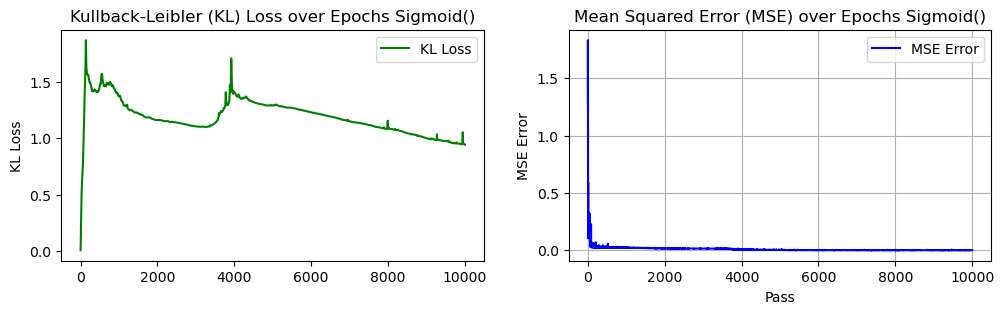

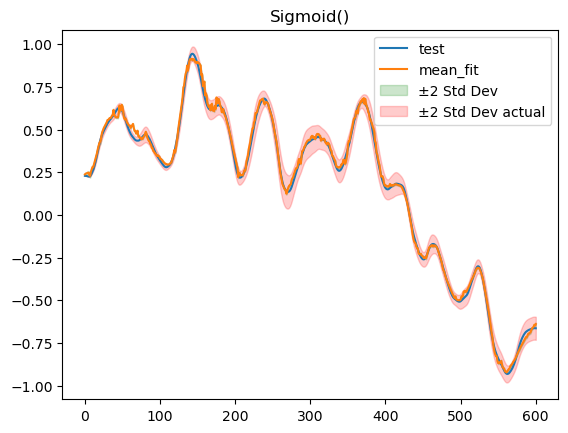

In [101]:
plotter(io,op,model_variables,activations,mse_list,kl_losses)

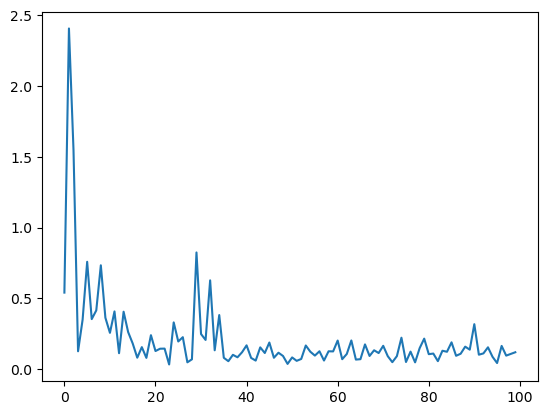

In [70]:
plt.plot(mse_list)

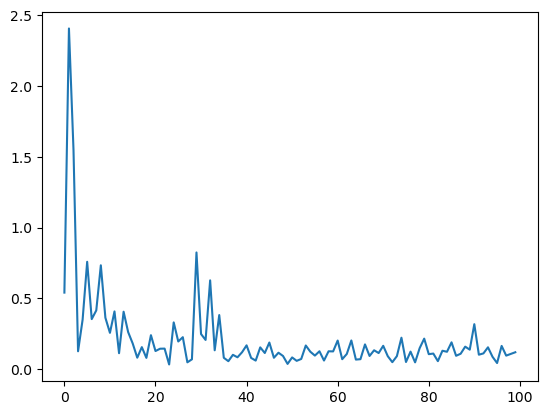

In [72]:
plt.plot(mse_list)

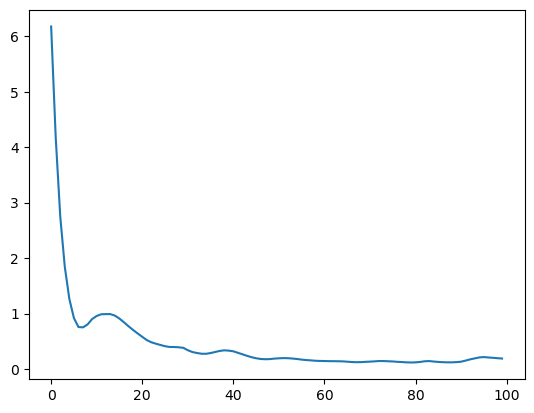

In [73]:
plt.plot(kl_losses)

In [852]:
shuffled_indicies.shape

torch.Size([30050])

In [853]:
op.shape

(1000, 601)

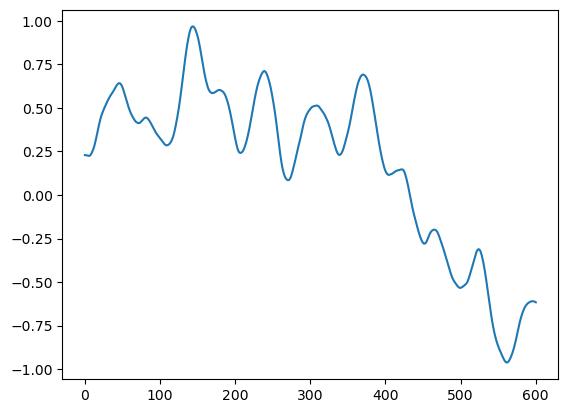

In [859]:
plt.plot(op[90,:])

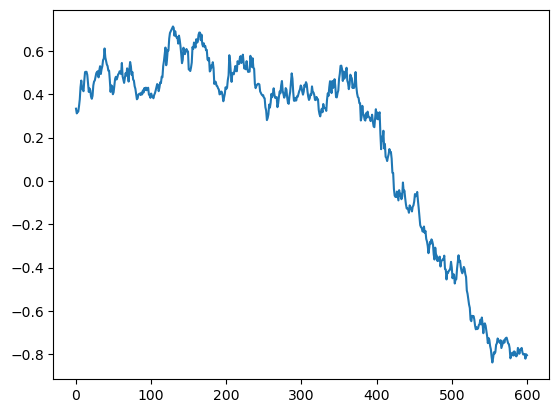

In [860]:
plt.plot(mean_fit)

 MEAN VALIDATION ERROR-----0.2815885512919978
 SD VALIDATION ERROR------0.7115988068869733


{'prior_mu': 0.0, 'prior_sigma': 1, 'posterior_mu_init': 0.0, 'posterior_rho_init': 0.0, 'type': 'Reparameterization', 'moped_enable': True, 'moped_delta': 0.5, 'learning_rate': 0.1, 'kl_weight': 1.5, 'iterations': 50}


Sequential(
  (0): LinearReparameterization()
  (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): LinearReparameterization()
  (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): LinearReparameterization()
  (7): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)




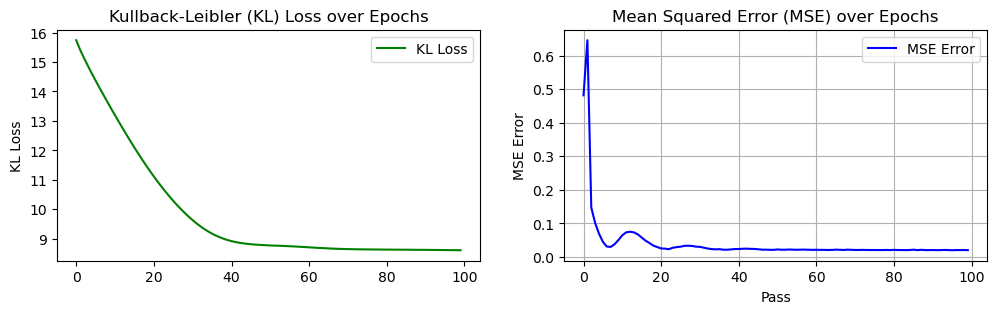

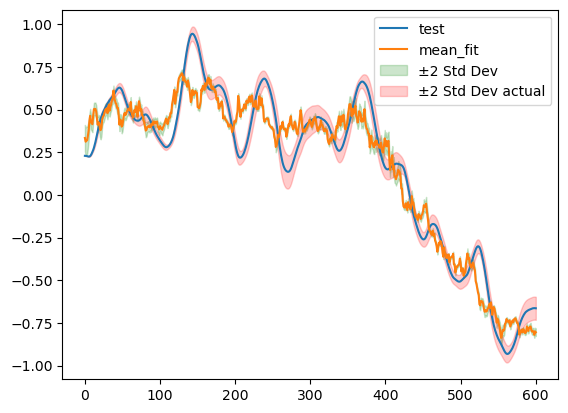

## The displacement plot

In [177]:
y_outside=op[50:,:]

In [179]:
y_outside_mean=np.mean(y_outside,axis=0)

In [182]:
y_outside_mean.shape

(601,)

In [183]:
y_outside_sd=np.std(y_outside,axis=0)

In [184]:
y_outside_sd.shape

(601,)

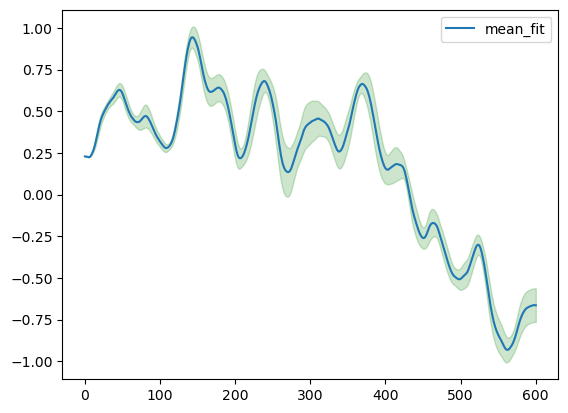

In [187]:
#plt.plot(np.arange(0,601),y_test.data.numpy(),label='test')
plt.plot(y_outside_mean,label='mean_fit')
plt.legend()
plt.fill_between(np.arange(0,601), (y_outside_mean - 3 * y_outside_sd), (y_outside_mean + 3 * y_outside_sd), color='green', alpha=0.2, label='±2 Std Dev')

In [45]:
cost


tensor([1.3171], grad_fn=<AddBackward0>)

In [49]:
x_torch.shape

torch.Size([1000, 601, 2])

In [50]:
y_torch.shape

torch.Size([1000, 1, 601])

### Normal NNs

In [30]:
num_layers = len(list(model_car.children()))
model_info = {
    'num_layers': num_layers,
    'units_per_layer': [1,10,1],
    'mse_loss': mse_loss,
    'mse_list': mse_list,
    'rel_mse_list': rel_mse_list,
    'rel_mse_loss': rel_mse,
    'min_loss': min(mse_list),
    'min_rel_mse': min(rel_mse_list),
    'kl_divergence': kl,
    'kl_weight': kl_weight,
    'learning_rate': lr
}

In [31]:
direct

'C:\\Users\\ad3389\\OneDrive - Northern Arizona University\\Desktop\\BNN_Multi_fidelity_TL\\logs'

In [32]:
def log_information_with_loss_list(log_file, model_info,direct):
    total_path=os.path.join(direct,log_file)
    
    with open(total_path, 'a') as file:
        
        file.write('\n' * 5)
                
        file.write(f"Number of Layers: {model_info['num_layers']}\n")
        file.write(f"Units in Each Layer: {model_info['units_per_layer']}\n")
        file.write(f"mse_loss: {model_info['mse_loss']}\n")
        file.write(f"rel_mse_loss: {model_info['rel_mse_loss']}\n")
        file.write(f"Minimum Loss: {model_info['min_loss']}\n")
        file.write(f"min_rel_mse: {model_info['min_rel_mse']}\n")
        file.write(f"KL Divergence: {model_info['kl_divergence']}\n")
        file.write(f"KL Weight: {model_info['kl_weight']}\n")
        file.write(f"Learning Rate: {model_info['learning_rate']}\n\n")
        file.write(f"mse_list: {model_info['mse_list']}\n")
        file.write(f"rel_mse_list: {model_info['rel_mse_list']}\n")

        print("Log file created successfully.")



In [33]:
def log_information(log_file, model_info,direct):
    
    total_path=os.path.join(direct,log_file)
    
    with open(total_path, 'a') as file:
                
        file.write(f"Number of Layers: {model_info['num_layers']}\n")
        file.write(f"Units in Each Layer: {model_info['units_per_layer']}\n")
        file.write(f"mse_loss: {model_info['mse_loss']}\n")
        file.write(f"rel_mse_loss: {model_info['rel_mse_loss']}\n")
        file.write(f"Minimum Loss: {model_info['min_loss']}\n")
        file.write(f"min_rel_mse: {model_info['min_rel_mse']}\n")
        file.write(f"KL Divergence: {model_info['kl_divergence']}\n")
        file.write(f"KL Weight: {model_info['kl_weight']}\n")
        file.write(f"Learning Rate: {model_info['learning_rate']}\n\n")


        print("Log file created successfully.")



In [34]:
log_information_with_loss_list('log_{}_loss_list.txt'.format(today_date), model_info,direct)

Log file created successfully.


In [35]:
log_information('log_{}.txt'.format(today_date), model_info,direct)

Log file created successfully.


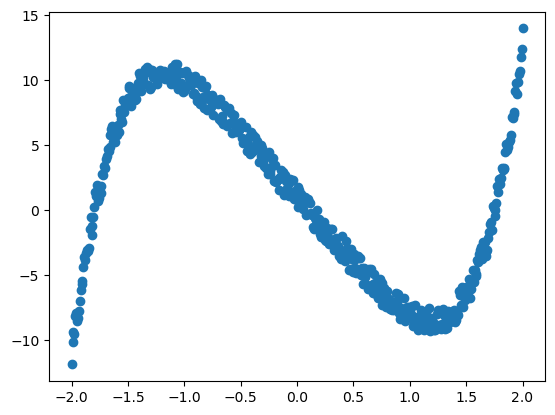

In [86]:
x = torch.linspace(-2, 2, 500)
y = x.pow(5) -10* x.pow(1) + 2*torch.rand(x.size())
x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)

plt.scatter(x.data.numpy(), y.data.numpy())
plt.show()

In [90]:
x.shape

torch.Size([500, 1])

In [107]:
y.shape

torch.Size([500, 1])

In [535]:
mse_list

[array(0.24159057, dtype=float32),
 array(0.08028367, dtype=float32),
 array(0.06811801, dtype=float32),
 array(0.5710897, dtype=float32),
 array(0.23043574, dtype=float32),
 array(0.2785191, dtype=float32),
 array(0.32235688, dtype=float32),
 array(0.32419676, dtype=float32),
 array(0.32601178, dtype=float32),
 array(1.1493932, dtype=float32),
 array(0.23058666, dtype=float32),
 array(0.46971875, dtype=float32),
 array(0.23750074, dtype=float32),
 array(0.61541575, dtype=float32),
 array(0.5440377, dtype=float32),
 array(0.09447826, dtype=float32),
 array(0.39997557, dtype=float32),
 array(0.13477156, dtype=float32),
 array(0.14459395, dtype=float32),
 array(0.32763997, dtype=float32),
 array(0.28388527, dtype=float32),
 array(0.3671469, dtype=float32),
 array(0.41327217, dtype=float32),
 array(0.07247515, dtype=float32),
 array(0.7752722, dtype=float32),
 array(0.6617238, dtype=float32),
 array(0.17378263, dtype=float32),
 array(0.45089757, dtype=float32),
 array(0.656727, dtype=floa

In [67]:
torch.cuda.is_available()

False

In [2]:
import sys

'C:\\Users\\ad3389\\AppData\\Local\\anaconda3\\envs\\bifidelity_2\\python.exe'

In [4]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
